In [2]:
# Import base libraries for EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import os
import glob
from PIL import Image
import re
import seaborn as sns

# Import TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# Import the data from the main file(s)
file_path = "C:/Users/colts/OneDrive/Desktop/COMP 4449/Multi-class Weather Dataset"
folders = os.listdir(file_path)
ext = ['jpg','jpeg']

# Folders for modeling
print(folders)

# Collect images and their respective labels
def CollectImages(PATH, folder, image_ext):
    images = []
    for ext in image_ext:
        for file in glob.glob(PATH + "/" + folder + '/*.' + ext):
            # Using Pillow to reshape and convert the images
            images.append(file)

    # Displays number of images in each folder
    print(f"Number of Images in folder {folder}: {len(images)}")
    
    # Shuffles for randomness
    np.random.shuffle(images)
    
    # Returns the list of images along with an index of values that changes each run
    return images, np.array([folder for i in range(len(images))])

['Cloudy', 'Hail', 'Lightning', 'Rain', 'Shine', 'Snow', 'Sunrise']


In [5]:
# I want to re-read the files in as categorical, reducing the time needed to run a deep-layer CNN
image_h = 224
image_w = 224

fields = len(folders)
train_ds = tf.keras.utils.image_dataset_from_directory(
    file_path,
    validation_split=0.2,
    subset="training",
    label_mode="categorical",
    seed=12345,
    image_size=(image_w, image_h),
    batch_size=64)

val_ds = tf.keras.utils.image_dataset_from_directory(
    file_path,
    validation_split=0.2,
    subset="validation",
    label_mode="categorical",
    seed=12345,
    image_size=(image_w, image_h),
    batch_size=64)

Found 2245 files belonging to 7 classes.
Using 1796 files for training.
Found 2245 files belonging to 7 classes.
Using 449 files for validation.


In [6]:
# Implement ResNet152
weather_model_ResNet152 = keras.applications.resnet.ResNet152(weights='imagenet', include_top=False, 
                                                              input_shape=(image_h, image_w, 3))

# Trainability
weather_model_ResNet152.trainable = False

# Build like a Sequential
run_model = keras.Sequential([
    weather_model_ResNet152,
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(fields, activation="softmax")
])

# Summary
run_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 2048)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 7)                 129031    
                                                                 
Total params: 58,499,975
Trainable params: 129,031
Non-trainable params: 58,370,944
_________________________________________________________________


#### Far deeper model

In [7]:
# Compile
run_model.compile(optimizer="Adam", loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
epochs = 15

# Fit and run
history_4 = run_model.fit(
        train_ds, 
        validation_data=val_ds, 
        epochs=epochs
    )

Epoch 1/15
29/29 [==============================] - 27s 632ms/step - loss: 2.3400 - accuracy: 0.7428 - val_loss: 0.4446 - val_accuracy: 0.9243
Epoch 2/15
29/29 [==============================] - 16s 534ms/step - loss: 0.2708 - accuracy: 0.9571 - val_loss: 0.4092 - val_accuracy: 0.9332
Epoch 3/15
29/29 [==============================] - 16s 534ms/step - loss: 0.0886 - accuracy: 0.9805 - val_loss: 0.4779 - val_accuracy: 0.9287
Epoch 4/15
29/29 [==============================] - 16s 537ms/step - loss: 0.0173 - accuracy: 0.9944 - val_loss: 0.4400 - val_accuracy: 0.9198
Epoch 5/15
29/29 [==============================] - 16s 538ms/step - loss: 0.0088 - accuracy: 0.9972 - val_loss: 0.5765 - val_accuracy: 0.9265
Epoch 6/15
29/29 [==============================] - 16s 538ms/step - loss: 0.0063 - accuracy: 0.9983 - val_loss: 0.5188 - val_accuracy: 0.9265
Epoch 7/15
29/29 [==============================] - 16s 542ms/step - loss: 0.0022 - accuracy: 0.9983 - val_loss: 0.3921 - val_accuracy: 0.9354

In [8]:
# Save the model for future use
# keras.models.save_model(run_model, "ResNet152_WX.h5")

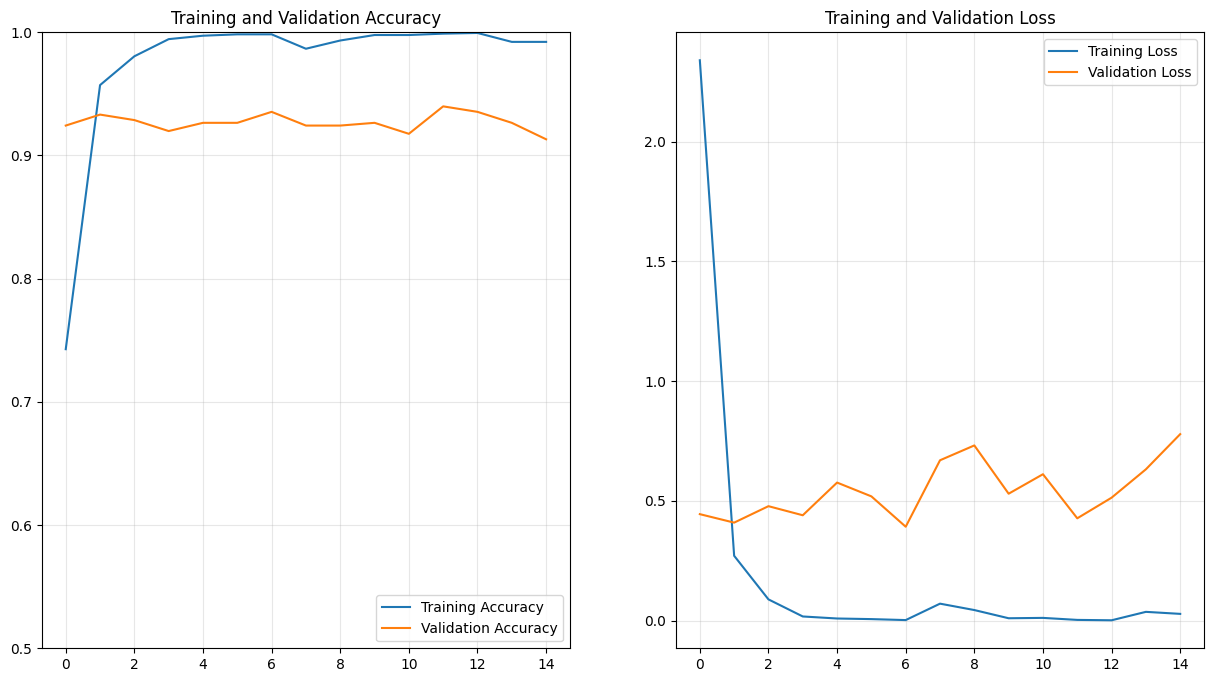

In [10]:
# Plots depicting second models accuracy/loss
training_acc = history_4.history['accuracy']
validation_acc = history_4.history['val_accuracy']

training_loss = history_4.history['loss']
validation_loss = history_4.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_acc, label='Training Accuracy')
plt.plot(epochs_range, validation_acc, label='Validation Accuracy')
plt.ylim([0.5,1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(alpha=0.3)
plt.show()